# **1. Import Library**

Pada tahap ini, kami mengimpor beberapa pustaka (library) Python yang dibutuhkan untuk analisis data dan pembangunan model machine learning.

In [41]:
import pandas as pd
import numpy as np  

# **2. Memuat Dataset**

In [42]:
df = pd.read_csv('dataset_edit.csv')

In [43]:
df.drop(columns=['id_umkm','nama_usaha'], inplace=True)

In [44]:
cols_to_int = [
    'tenaga_kerja_perempuan',
    'tenaga_kerja_laki_laki',
    'aset',
    'omset',
    'kapasitas_produksi',
    'tahun_berdiri',
    'laba',
    'biaya_karyawan',
    'jumlah_pelanggan'
]

for col in cols_to_int:
    df[col] = pd.to_numeric(df[col], errors='coerce').astype('Int64')
# Cek kembali tipe data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13564 entries, 0 to 13563
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   jenis_usaha             13467 non-null  object
 1   tenaga_kerja_perempuan  13408 non-null  Int64 
 2   tenaga_kerja_laki_laki  13429 non-null  Int64 
 3   aset                    13422 non-null  Int64 
 4   omset                   13423 non-null  Int64 
 5   marketplace             13447 non-null  object
 6   kapasitas_produksi      13400 non-null  Int64 
 7   status_legalitas        13470 non-null  object
 8   tahun_berdiri           13436 non-null  Int64 
 9   laba                    13407 non-null  Int64 
 10  biaya_karyawan          13430 non-null  Int64 
 11  jumlah_pelanggan        13412 non-null  Int64 
dtypes: Int64(9), object(3)
memory usage: 1.4+ MB


In [45]:
df.drop(columns=['kapasitas_produksi'], inplace=True)

In [46]:
df["persentase_laki"] = (df["tenaga_kerja_laki_laki"] / (df["tenaga_kerja_laki_laki"]+df["tenaga_kerja_perempuan"])) * 100

In [47]:
df["net_profit_margin"] = (df["laba"] / df["omset"])*100

In [48]:
df.drop(columns=['tenaga_kerja_laki_laki','tenaga_kerja_perempuan'], inplace=True)

In [49]:
df.isnull().sum()

jenis_usaha           97
aset                 142
omset                141
marketplace          117
status_legalitas      94
tahun_berdiri        128
laba                 157
biaya_karyawan       134
jumlah_pelanggan     152
persentase_laki      291
net_profit_margin    298
dtype: int64

In [50]:
df = df.dropna(subset=['status_legalitas'])

In [51]:
test = df[(df["status_legalitas"] == "unknown") | (df["status_legalitas"].isna())]
df = df.drop(index=test.index)

In [52]:
df.isnull().sum()

jenis_usaha           97
aset                 140
omset                141
marketplace          117
status_legalitas       0
tahun_berdiri        127
laba                 157
biaya_karyawan       133
jumlah_pelanggan     151
persentase_laki      291
net_profit_margin    298
dtype: int64

In [53]:
X = df.drop('status_legalitas', axis=1)
y = df['status_legalitas']


In [54]:
y.isnull().sum()

0

In [55]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.experimental import enable_iterative_imputer  # <- HARUS duluan
from sklearn.impute import IterativeImputer, SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

num_features = X.select_dtypes(include=['number']).columns.tolist()
cat_features = X.select_dtypes(include=['object', 'category']).columns.tolist()

# Pipeline numerik
numeric_pipeline = Pipeline(steps=[
    ('imputer', IterativeImputer(random_state=42)),
    ('scaler', StandardScaler())
])

# Pipeline kategorikal
categorical_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

# Gabungan preprocessing
preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_pipeline, num_features),
    ('cat', categorical_pipeline, cat_features)
])


# **3. Data Splitting**

Tahap Data Splitting bertujuan untuk memisahkan dataset menjadi dua bagian: data latih (training set) dan data uji (test set).

In [56]:
# Split data
from sklearn.model_selection import train_test_split, cross_val_score
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
X_train_processed = preprocessor.fit_transform(X_train)
X_val_processed = preprocessor.transform(X_val)

# **4. Membangun Model Klasifikasi**


## **a. Membangun Model Klasifikasi**

Setelah memilih algoritma klasifikasi yang sesuai, langkah selanjutnya adalah melatih model menggunakan data latih.

Berikut adalah tahapannya.
1. Pilih algoritma klasifikasi yang sesuai, seperti Logistic Regression, Decision Tree, Random Forest, atau K-Nearest Neighbors (KNN).
2. Latih model menggunakan data latih.

In [57]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.ensemble import (
    RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier,
    HistGradientBoostingClassifier, AdaBoostClassifier
)
from sklearn.linear_model import (
    LogisticRegression, LogisticRegressionCV, RidgeClassifier
)
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier

# Fungsi evaluasi model
import time
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def all_model(list_model, X_train, X_test, y_train, y_test):
    result = []
    for model_name, model in list_model.items():
        start_time = time.time()  # Mulai pencatatan waktu
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        end_time = time.time()    # Selesai pencatatan waktu

        running_time = end_time - start_time

        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
        recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
        f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)

        hasil = {
            'Model': model_name,
            'Accuracy': accuracy,
            'F1 Score': f1,
            'Precision': precision,
            'Recall': recall,
            'Running Time (s)': round(running_time, 4)  # waktu dalam detik, dibulatkan 4 desimal
        }

        result.append(hasil)
    
    return pd.DataFrame(result).sort_values(by="Accuracy", ascending=False)


# Daftar model yang dikelompokkan berdasarkan jenisnya
list_of_model = {
    # Model Linear
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Logistic Regression CV": LogisticRegressionCV(max_iter=10000),
    "Ridge Classifier": RidgeClassifier(),
    
    # Model Klasik
    "Support Vector Machine": SVC(),
    "K-Nearest Neighbors": KNeighborsClassifier(n_neighbors=5),
    "Naive Bayes Gaussian": GaussianNB(),
    "Naive Bayes Bernoulli": BernoulliNB(),

    # Model Tree-Based
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "Extra Trees": ExtraTreesClassifier(n_estimators=100, random_state=42),

    # Model Boosting
    "Gradient Boosting": GradientBoostingClassifier(n_estimators=100, random_state=42),
    "AdaBoost": AdaBoostClassifier(n_estimators=100, random_state=42),
    "XGBoost": XGBClassifier(random_state=42),
    "CatBoost": CatBoostClassifier(random_state=42, logging_level='Silent')
}

Algoritma Modelling:  

1. **Import Library** 
   - Mengimpor berbagai model klasifikasi seperti **Logistic Regression, Decision Tree, Random Forest, SVM, KNN, Naïve Bayes, serta model boosting (XGBoost, CatBoost, Gradient Boosting, AdaBoost, LightGBM, dll.)**.  

2. **Fungsi Evaluasi (`all_model`)**  
   - Menerima daftar model dan dataset (X_train, X_test, y_train, y_test).  
   - Melatih setiap model pada `X_train` dan `y_train`, lalu membuat prediksi pada `X_test`.  
   - Menghitung metrik evaluasi: **Accuracy, Precision, Recall, dan F1-Score**.  
   - Mengembalikan hasil evaluasi dalam bentuk DataFrame yang diurutkan berdasarkan **akurasi tertinggi**.  

3. **Daftar Model (`list_of_model`)**  
   - Mengelompokkan berbagai model berdasarkan jenisnya: **linear models (Logistic Regression, Ridge), non-linear models (SVM, KNN, Naïve Bayes), tree-based models (Decision Tree, Random Forest, Extra Trees), dan boosting models (XGBoost, CatBoost, AdaBoost, dll.)**.  

## **b. Evaluasi Model Klasifikasi**

In [58]:
# Mapping status_legalitas ke angka
mapping = {
    'Belum Terdaftar': 0,
    'Terdaftar': 1,
}

y_train = y_train.map(mapping)
y_val = y_val.map(mapping)


In [59]:
print(y_train.value_counts(normalize=True))


status_legalitas
1    0.514655
0    0.485345
Name: proportion, dtype: float64


In [60]:
results = all_model(list_of_model, X_train_processed, X_val_processed, y_train, y_val)
results

c:\Users\acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


,Model,Accuracy,F1 Score,Precision,Recall,Running Time (s)
10,Gradient Boosting,0.519539,0.506264,0.518981,0.519539,2.7841
13,CatBoost,0.513956,0.511555,0.513186,0.513956,8.8592
11,AdaBoost,0.513584,0.508401,0.512552,0.513584,1.3341
1,Logistic Regression CV,0.508001,0.342262,0.258066,0.508001,0.2420
3,Support Vector Machine,0.507257,0.497452,0.505550,0.507257,6.7459
12,XGBoost,0.506513,0.504969,0.505801,0.506513,0.5385
0,Logistic Regression,0.506141,0.473028,0.502955,0.506141,0.0306
6,Naive Bayes Bernoulli,0.506141,0.490643,0.503921,0.506141,0.0000
7,Decision Tree,0.505769,0.505774,0.505780,0.505769,0.1847
2,Ridge Classifier,0.505024,0.471519,0.501457,0.505024,0.0000


In [61]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report

# Inisialisasi dan latih model dengan Gradient Boosting sebagai model terbaik
model = GradientBoostingClassifier(n_estimators=100, random_state=42)
model.fit(X_train_processed, y_train)

# Prediksi pada data validasi
y_pred = model.predict(X_val_processed)

# Buat classification report
report = classification_report(y_val, y_pred)
print("Classification Report:\n")
print(report)


Classification Report:

              precision    recall  f1-score   support

           0       0.52      0.35      0.42      1322
           1       0.52      0.68      0.59      1365

    accuracy                           0.52      2687
   macro avg       0.52      0.52      0.50      2687
weighted avg       0.52      0.52      0.51      2687



Selanjutnya hasil prediksi akan disimpan dan digabungkan dengan data asli

In [68]:
# Gabungkan prediksi dengan X_val asli
X_val_with_pred = X_val.copy()  
X_val_with_pred['y_pred'] = y_pred

# Simpan ke CSV
X_val_with_pred.to_csv('hasil_prediksi_validasi.csv', index=False)

print("File hasil_prediksi_validasi.csv berhasil dibuat.")

File hasil_prediksi_validasi.csv berhasil dibuat.


In [66]:
import shap
import numpy as np
import pandas as pd
from sklearn.utils import shuffle  # Untuk fungsi shuffle jika dibutuhkan

# Cek jika hasil preprocessing adalah sparse matrix, konversi ke array
X_train_array = X_train_processed.toarray() if hasattr(X_train_processed, "toarray") else X_train_processed
X_val_array = X_val_processed.toarray() if hasattr(X_val_processed, "toarray") else X_val_processed

# Ambil feature importance biasa (optional)
feature_importance = model.feature_importances_

# Dapatkan nama fitur dari preprocessor
feature_names = preprocessor.get_feature_names_out()

# Buat SHAP explainer khusus untuk model pohon
explainer = shap.TreeExplainer(model)

# Hitung SHAP values pada data validasi
shap_values = explainer.shap_values(X_val_array)

# Ambil nilai SHAP (jika multiclass, bisa pilih satu)
if isinstance(shap_values, list):
    shap_vals = shap_values[0]  # ambil kelas pertama (ubah jika perlu)
else:
    shap_vals = shap_values

# Hitung rata-rata absolut SHAP value per fitur
mean_abs_shap = np.abs(shap_vals).mean(axis=0)

# Hitung persentase kontribusi tiap fitur
percent_shap = 100 * mean_abs_shap / mean_abs_shap.sum()

# Buat DataFrame hasil SHAP
importance_shap_df = pd.DataFrame({
    'Feature': feature_names,
    'SHAP Importance (%)': percent_shap
}).sort_values(by='SHAP Importance (%)', ascending=False)

# Tampilkan hasil
print(importance_shap_df)


                               Feature  SHAP Importance (%)
3                            num__laba            20.045110
7               num__net_profit_margin            18.679559
2                   num__tahun_berdiri            13.372216
1                           num__omset            10.191739
6                 num__persentase_laki             9.149325
5                num__jumlah_pelanggan             8.611671
4                  num__biaya_karyawan             8.297400
0                            num__aset             3.525576
17             cat__marketplace_Lazada             2.300187
12         cat__jenis_usaha_Pendidikan             2.064676
19          cat__marketplace_Tokopedia             1.476372
11  cat__jenis_usaha_Makanan & Minuman             0.736858
16          cat__marketplace_Bukalapak             0.598363
9                cat__jenis_usaha_Jasa             0.497814
21            cat__marketplace_unknown             0.204895
15            cat__jenis_usaha_unknown  

In [67]:
importance_shap_df.to_csv('shap_importance.csv', index=False)

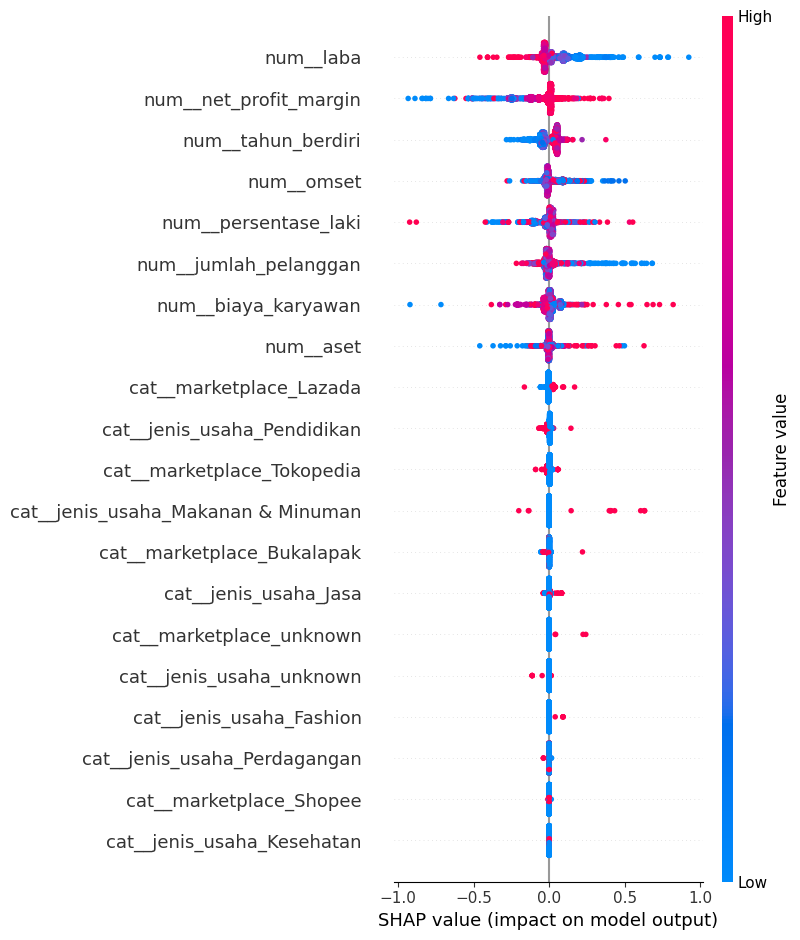

In [ ]:
# Buat explainer untuk model terbaik
explainer = shap.TreeExplainer(model)

# Hitung SHAP values untuk data validasi (X_val_processed)
shap_values = explainer.shap_values(X_val_processed)

# Tampilkan summary plot SHAP values (beeswarm)
shap.summary_plot(shap_values, X_val_processed, feature_names=feature_names)
